In [10]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

In [11]:
# --- Parameters ---
num_cells = 180
timesteps = 100
sigma_adn = 40
sigma_rsc = 40
dt = 1.0
tau = 50.0
gamma = 5.0
xi = 0.5
step_size = 5.0
vis_strength = 5.0
fov_angle = 90
fov_half = fov_angle / 2

In [12]:
preferred_directions = np.linspace(0, 360, num_cells, endpoint=False)
theta = np.deg2rad(preferred_directions)
preferred_directions_vis = preferred_directions.copy()

In [13]:
# Gaussian bump
def circular_gaussian(x, mu, sigma):
    delta = np.angle(np.exp(1j * np.deg2rad(x - mu)), deg=True)
    return np.exp(-0.5 * (delta / sigma) ** 2)

In [14]:
# Build Gaussian weight matrix
def build_weight_matrix(pfds_pre, pfds_post, sigma, strength):
    W = np.zeros((len(pfds_post), len(pfds_pre)))
    for i, post in enumerate(pfds_post):
        for j, pre in enumerate(pfds_pre):
            delta = np.angle(np.exp(1j * np.deg2rad(post - pre)), deg=True)
            W[i, j] = np.exp(-0.5 * (delta / sigma) ** 2)
        W[i, :] /= W[i, :].sum()
        W[i, :] *= strength
    return W

In [15]:
# Weight matrices
w4 = build_weight_matrix(preferred_directions, preferred_directions, sigma=30, strength=120)
w5 = build_weight_matrix(preferred_directions, preferred_directions, sigma=10, strength=10)

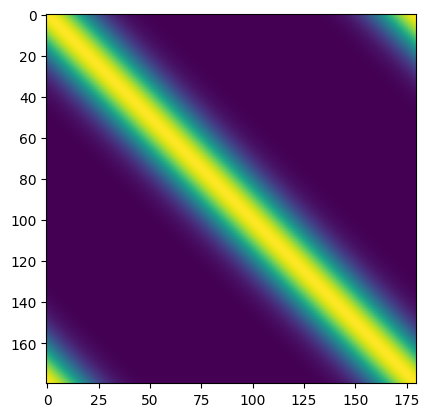

In [16]:
plt.imshow(w4)

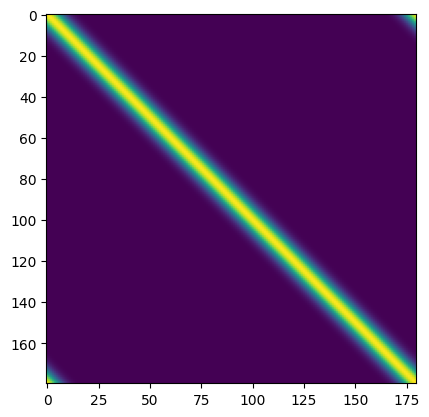

In [17]:
plt.imshow(w5)

In [18]:
# Initialization
true_hd = 0.0
x_est = 0.0
activity_adn = circular_gaussian(preferred_directions, x_est, sigma_adn)
activity_rsc = np.zeros(num_cells)
firing_rate_adn = np.maximum(0, np.tanh(activity_adn))
firing_rate_rsc = np.maximum(0, np.tanh(activity_rsc))

In [19]:
# Tracking
true_hd_over_time = [true_hd]
x_est_over_time = [x_est]
firing_rate_adn_over_time = [firing_rate_adn.copy()]
firing_rate_rsc_over_time = [firing_rate_rsc.copy()]
tracking_error_over_time = []
estimation_error_over_time = []

# Simulation loop
for t in range(1, timesteps):
    delta = np.random.uniform(-step_size, step_size)
    true_hd = (true_hd + delta) % 360
    true_hd_over_time.append(true_hd)

    noise = np.random.normal(loc=xi * delta, scale=xi * abs(delta))
    x_est = (true_hd + noise) % 360
    x_est_over_time.append(x_est)

    # Estimation error
    est_error = np.angle(np.exp(1j * np.deg2rad(x_est - true_hd)), deg=True)
    estimation_error_over_time.append(est_error)

    # VIS input (binary FOV logic)
    delta_vis = np.angle(np.exp(1j * np.deg2rad(preferred_directions_vis - true_hd)), deg=True)
    vis_activity = (np.abs(delta_vis) <= fov_half).astype(float)
    vis_input = vis_strength * vis_activity

    # ADN update
    input_adn_pi = circular_gaussian(preferred_directions, x_est, sigma_adn)
    input_adn_from_rsc = w5 @ firing_rate_rsc
    input_adn = input_adn_pi + input_adn_from_rsc
    activity_adn += input_adn - gamma * np.mean(firing_rate_adn) - (dt / tau) * activity_adn
    activity_adn = np.clip(activity_adn, 0, None)
    firing_rate_adn = np.maximum(0, np.tanh(activity_adn))

    # RSC update
    input_rsc_from_adn = w4 @ firing_rate_adn
    total_rsc_input = input_rsc_from_adn + vis_input
    activity_rsc += total_rsc_input - gamma * np.mean(firing_rate_rsc) - (dt / tau) * activity_rsc
    activity_rsc = np.clip(activity_rsc, 0, None)
    firing_rate_rsc = np.maximum(0, np.tanh(activity_rsc))

    # Tracking error
    cos_sum = np.sum(firing_rate_rsc * np.cos(np.deg2rad(preferred_directions)))
    sin_sum = np.sum(firing_rate_rsc * np.sin(np.deg2rad(preferred_directions)))
    bump_dir = (np.rad2deg(np.arctan2(sin_sum, cos_sum))) % 360
    error = np.angle(np.exp(1j * np.deg2rad(bump_dir - true_hd)), deg=True)
    tracking_error_over_time.append(error)

    # Store
    firing_rate_adn_over_time.append(firing_rate_adn.copy())
    firing_rate_rsc_over_time.append(firing_rate_rsc.copy())


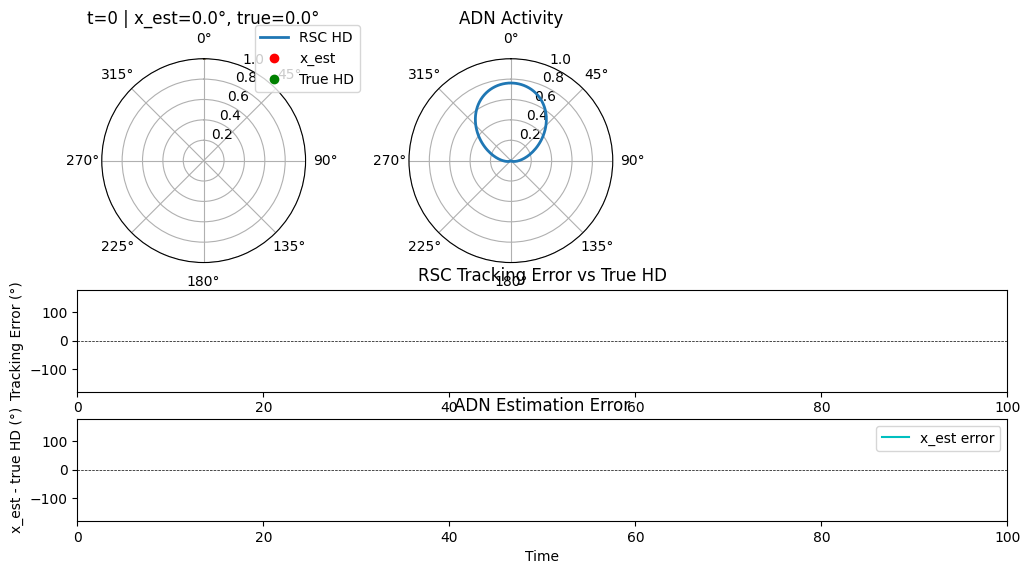

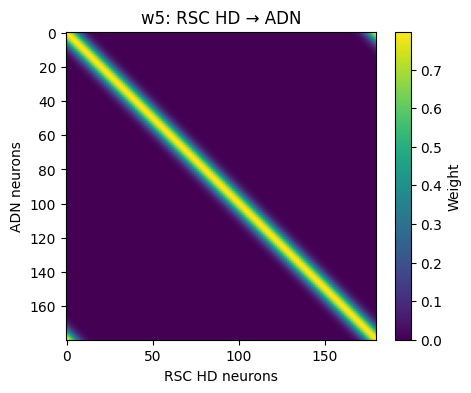

In [20]:
fig = plt.figure(figsize=(12, 6))
gs = fig.add_gridspec(3, 3, height_ratios=[1, 0.5, 0.5], width_ratios=[1.2, 1.2, 1.5])

# RSC HD
ax_polar = fig.add_subplot(gs[0, 0], polar=True)
ax_polar.set_theta_zero_location("N")
ax_polar.set_theta_direction(-1)
ax_polar.set_rlim(0, 1.0)
line_rsc, = ax_polar.plot([], [], lw=2, label='RSC HD')
marker_est, = ax_polar.plot([], [], 'ro', label='x_est')
marker_true, = ax_polar.plot([], [], 'go', label='True HD')
ax_polar.legend(loc='upper right', bbox_to_anchor=(1.3, 1.2))

# ADN HD
ax_adn = fig.add_subplot(gs[0, 1], polar=True)
ax_adn.set_theta_zero_location("N")
ax_adn.set_theta_direction(-1)
ax_adn.set_rlim(0, 1.0)
line_adn, = ax_adn.plot([], [], lw=2, label='ADN')
ax_adn.set_title("ADN Activity")

# RSC tracking error
ax_err = fig.add_subplot(gs[1, :])
ax_err.set_xlim(0, timesteps)
ax_err.set_ylim(-180, 180)
ax_err.set_xlabel("Time")
ax_err.set_ylabel("Tracking Error (°)")
ax_err.set_title("RSC Tracking Error vs True HD")
line_err, = ax_err.plot([], [], 'm-')
ax_err.axhline(0, color='k', linestyle='--', linewidth=0.5)

# ADN estimation error
ax_est = fig.add_subplot(gs[2, :])
ax_est.set_xlim(0, timesteps)
ax_est.set_ylim(-180, 180)
ax_est.set_xlabel("Time")
ax_est.set_ylabel("x_est - true HD (°)")
ax_est.set_title("ADN Estimation Error")
line_est, = ax_est.plot([], [], 'c-', label='x_est error')
ax_est.axhline(0, color='k', linestyle='--', linewidth=0.5)
ax_est.legend()

# Static weight matrix
fig_w, ax_w = plt.subplots(figsize=(5, 4))
im_w = ax_w.imshow(w5, aspect='auto', cmap='viridis')
ax_w.set_title("w5: RSC HD → ADN")
ax_w.set_xlabel("RSC HD neurons")
ax_w.set_ylabel("ADN neurons")
plt.colorbar(im_w, ax=ax_w, label='Weight')

# Update function
def update(frame):
    line_rsc.set_data(theta, firing_rate_rsc_over_time[frame])
    line_adn.set_data(theta, firing_rate_adn_over_time[frame])
    marker_est.set_data([np.deg2rad(x_est_over_time[frame])], [1.05])
    marker_true.set_data([np.deg2rad(true_hd_over_time[frame])], [1.05])
    ax_polar.set_title(f"t={frame} | x_est={x_est_over_time[frame]:.1f}°, true={true_hd_over_time[frame]:.1f}°")
    x_vals = np.arange(1, frame + 1)
    line_err.set_data(x_vals, tracking_error_over_time[:frame])
    line_est.set_data(x_vals, estimation_error_over_time[:frame])
    return line_rsc, marker_est, marker_true, line_err, line_adn, line_est

# Create animation
ani = animation.FuncAnimation(
    fig, update,
    frames=timesteps,
    interval=100,
    blit=False,
    repeat=False
)

# Save to file
ani.save("plot_ani/rsc_adn_bidirection.gif", writer='pillow', fps=20)